In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (15,5)

In [2]:
def plot_acf_pacf_functions(df: pd.Series, lags=360):
    
    '''Funcion para hacer un grafico de la funcion de autocorrelacion (ACF) y autoco'''
    # Import Data
    # df = pd.read_csv('AirPassengers.csv')
    # Draw Plot
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
    plot_acf(df.fillna(method='ffill').tolist(), ax=ax1, lags=lags)
    plot_pacf(df.fillna(method='ffill').tolist(), ax=ax2, lags=lags)

    # Decorate
    # lighten the borders
    ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
    ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
    ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
    ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)
    
    # font size of tick labels
    ax1.tick_params(axis='both', labelsize=12)
    ax2.tick_params(axis='both', labelsize=12)
    ax1.set_title('ACF')
    ax2.set_title('PACF')

    plt.show()

# 0. Carga de datos

In [3]:
data = pd.read_csv('Eolica.csv', header=0, parse_dates=[0], index_col=[0], usecols=[0, 3], dayfirst=True, squeeze=True)
#data = data.set_index(pd.DatetimeIndex(data['Date']))
#data.index = pd.to_datetime(data.Date)
#data.drop(['Date'], axis=1, inplace=True)
data.head()

/tmp/ipykernel_160818/2696189952.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv('Eolica.csv', header=0, parse_dates=[0], index_col=[0], usecols=[0, 3], dayfirst=True, squeeze=True)


Date
2016-01-01    280606.59
2016-01-02    181981.12
2016-01-03    329470.87
2016-01-04    216707.38
2016-01-05    204859.99
Name: WindEnergy, dtype: float64

Se normalizan los datos en base a la potencia instalada: 17560 kw/h; 421440 kw/dia

In [4]:
#data['WindEnergy'] = data['WindEnergy'] /421440
data = data/421440

Se comprueba si hay valores perdidos

In [5]:
data.isnull().sum()

8

Se observa que tenemos datos perdidos. Se rellenan interpolando linealmente para evitar errores en los modelos y métodos de análisis.

In [6]:
data = data.interpolate(method='linear')

# 1. Análisis de la serie temporal

## 1.1 Gráfico de energía respecto del tiempo

<AxesSubplot: xlabel='Date'>

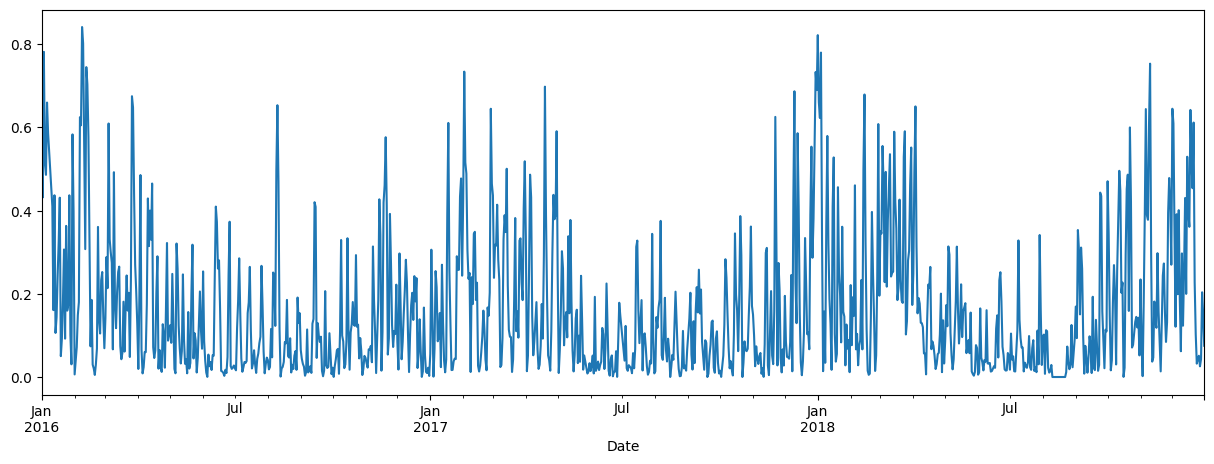

In [7]:
data.plot(figsize=(15, 5))

Se aprecia una serie no estacionaria ya que el valor medio cambia a lo largo del tiempo.

# 1.2 Descomposición en Season, Trend, Noise

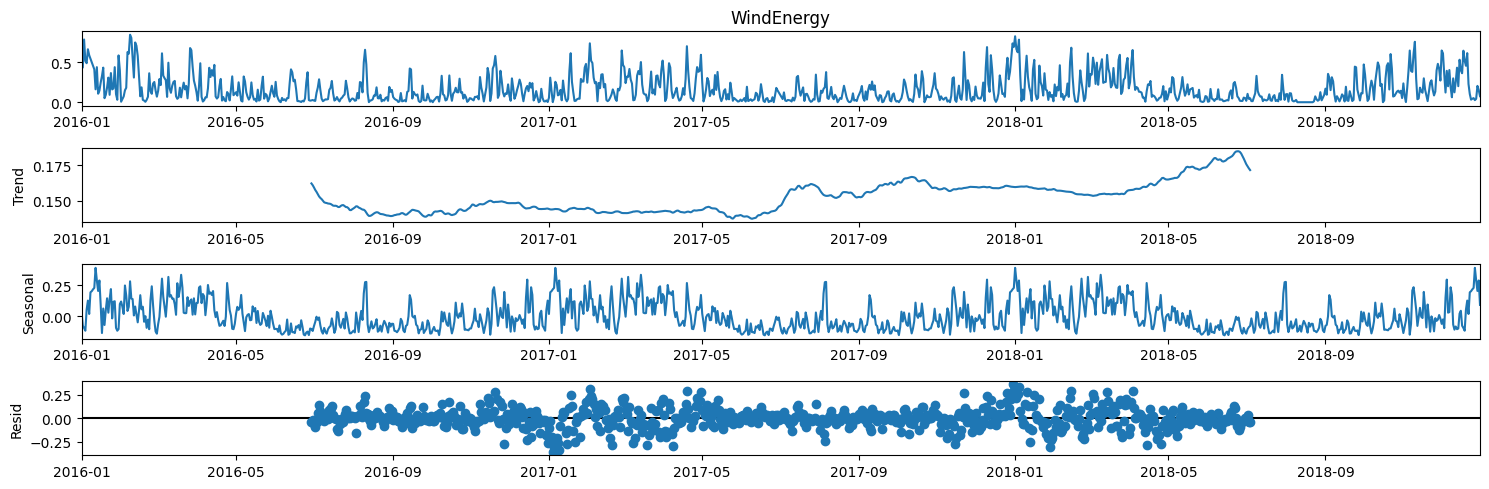

In [8]:
result = seasonal_decompose(data, period=360)
result.plot();

CONCLUSIONES

In [9]:
stat, p = adfuller(data)[:2]
print(stat, p)

-4.142391947640527 0.000823529530459151


In [10]:
stat, p, _,_ = kpss(data, regression='c')
print(stat, p)

0.19138133124408904 0.1


/home/daniel/anaconda3/envs/Amazon_Products_Reviews/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


CONCLUSIONES

# 1.3 Autocorrelación 

/home/daniel/anaconda3/envs/Amazon_Products_Reviews/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


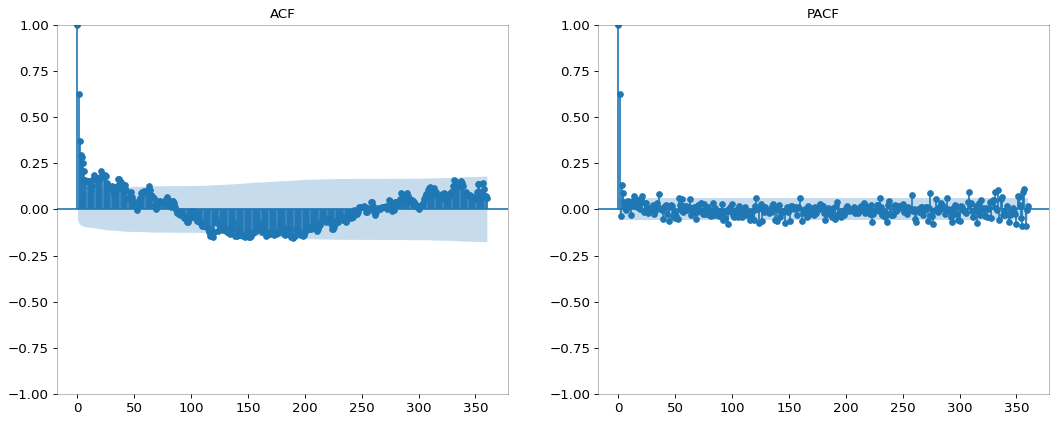

In [11]:
plot_acf_pacf_functions(data)

CONCLUSION

In [12]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]


# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error


# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

def sarima_configs(seasonal=[0,1]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [13]:
executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')

In [14]:
tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
scores = executor(tasks)

NameError: name 'cfg_list' is not defined

In [ ]:
if __name__ == '__main__':
    # define dataset
    X = data
    print(X)
    # data split
    n_test = 4
    # model configs
    cfg_list = sarima_configs()
    # grid search
    scores = grid_search(X, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)

In [ ]:
model=SARIMAX(X,order=(0, 0, 1),seasonal_order=(1, 0, 0, 12), trend='ct')
result = model.fit()

In [ ]:
result.summary()

In [ ]:
data['pred'] = result.predict(start=0,end=-1,dynamic=True)

In [ ]:
data[['WindEnergy', 'pred']].plot()